### ML Project - Implementation of:
# Dynamic Mode Decomposition for Real-Time Background/Foreground Separation in Video  
### Authors - J. Grosek and J. Nathan Kutz
Group 13  
By-  

Chinmay Parab		2019B4A70708G  
Shivam Chadha		2019B4AA0704G  
Vishesh Agrawal		2020A7PS0967G  


The implementation is done using PyDMD.  
PyDMD is a Python package that uses Dynamic Mode Decomposition for a data-driven model simplification based on spatiotemporal coherent structures.  
Using this we decompose the data into various frequency modes, and we use these modes to seperate the images into it's foreground and background component.

In [1]:
!pip install pydmd -q  # installing the pydmd package

In [2]:
# importing necessary packages to deal with image files, data and plotting.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob
from pydmd import DMD
from PIL import Image


In [3]:
# For using colab to import data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset 
We use the Highway dataset from the baseline category from [2014 ChanegeDetection.Net](http://jacarini.dinf.usherbrooke.ca/dataset2014#) (CDNET) dataset. 
The data is of a video of cars moving on a highway road. The resolution is 320x240 (RGB) and the number of frames is 1700.  
Before applying DMD we convert the image to grayscale and downsample it.  
Image shape - (320,240,3)  
After Processing - (96,128)


In [4]:
# add path to the folder containing images. It will take read all the .jpg files in the folder.
path = "/content/drive/MyDrive/ml project -Data/highway/input/*.jpg"  
filelist = glob.glob(path)


data = np.array([np.array(Image.open(fname).resize((128,96), resample = Image.LANCZOS)) for fname in filelist]) 

In [5]:
data.shape

(1700, 96, 128, 3)

In [6]:
def rgb2gray(image):
    """ 
    input : numpy array having rgb channels
    output : grayscale image in numpy array.
    Takes in a image and converts it to grayscale"""
    return np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

In [7]:
image  = rgb2gray(data)
m,n = image[1].shape

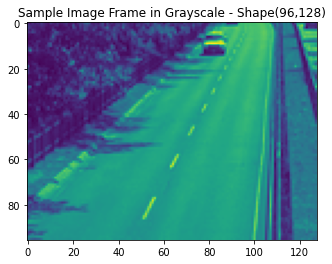

In [8]:
plt.imshow(image[0])
plt.title("Sample Image Frame in Grayscale - Shape(96,128)");

We take a segment of 30 frames from the total 1700 frames of the image.  
We start from frame 120 and go to frame 150. This frame has the car in the center.

$$
X_{DMD} =b_pϕ_pe^{ω_pt}  + \sum_{j≠p} b_jϕ_je^{ω_jt}
$$

Background(1st) and Foreground(2nd) components





In [9]:
img = image[120:150]
X = img.reshape(30,-1) # we reshape the image into single columns 

l = X.shape[0]   # size of the window
dmd = DMD(svd_rank=l-1, exact=True)   # we create the DMD instance and keep the svd_rank as the window lenght-1, as given in the paper
dmd.fit(X.T); # fitting to the Image
xdmd = dmd.reconstructed_data.T  # The reconstructed DMD image 

modes = dmd.modes   # Returns the reconstructed DMD as seperate modes. 

In [10]:
xdmd.shape  # 30 frames and (96*128) Columns

(30, 12288)

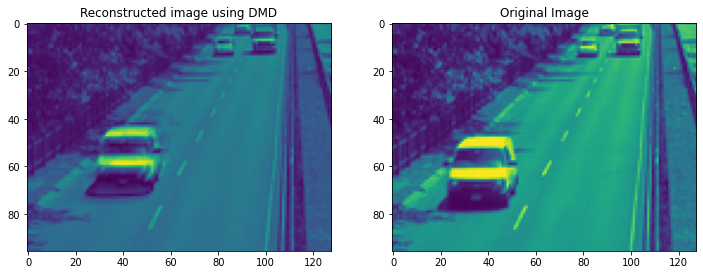

In [11]:
# Plotting the 2nd Frame

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(abs(xdmd[2].reshape(m,n)))
plt.title("Reconstructed image using DMD")
plt.subplot(122)
plt.imshow(img[2])
plt.title("Original Image");

Now we get the frequency modes.

In [12]:
eig = dmd.eigs  # gives the eigen values mu of the DMD reconstruction
wj = np.log(eig)  # We get the frequency modes, here delta(t) = 1.
ind = np.argmax(abs(wj)) # index of the frequency mode with the max (eigen value equivalent)

In [13]:
xsparse = modes[:,ind] # We select the highest frequency mode as the sparse component in our case

In [14]:
img.shape

(30, 96, 128)

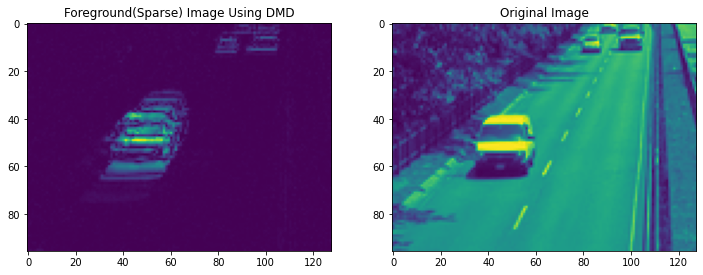

In [16]:
# Plotting Sparse vs original Image
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(abs(xsparse).reshape(m,n))
plt.title("Foreground(Sparse) Image Using DMD");
plt.subplot(122)
plt.imshow(img[ind])
plt.title("Original Image");


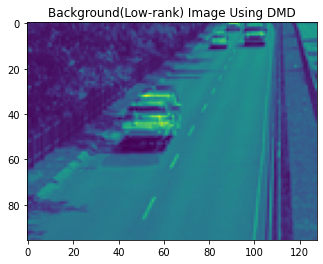

In [17]:
# Plotting Background
plt.imshow(abs(xdmd[ind]).reshape(m,n)-abs(xsparse).reshape(m,n));
plt.title("Background(Low-rank) Image Using DMD");

## HACK
Finding sparse from a single mode.
We take a mode take its values. Find the values below a threshold. We assume these to be the components with less importance and and hence make this part sparse, i.e make them 0.
Then we plot these values.  
This will not work for all modes and hence is not a proper solution.

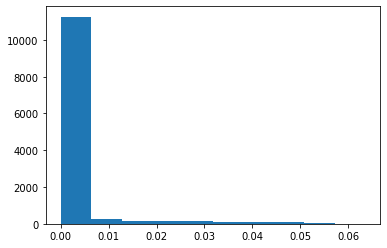

In [18]:
# histogram of absolute values of a single mode.
plt.hist(abs(modes)[:,1]);

Looking by eye we select a threshold of 0.0125.

In [19]:
ind = np.where( abs(modes[:,1])<=0.0125)  # low-rank components
indb = np.where( abs(modes[:,1])>0.0125)  # sparse components
sparse = xdmd.copy()
low_rank = xdmd.copy()
sparse[1,ind] = 0
low_rank[1,indb] = 0

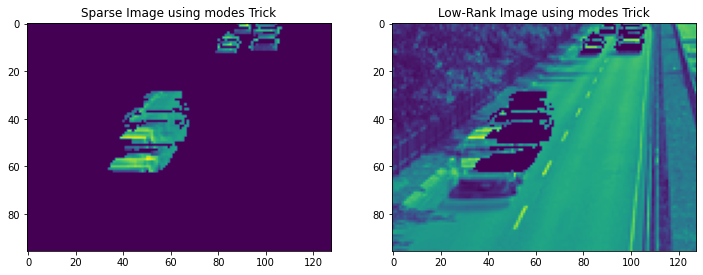

In [20]:
# Plotting Sparse vs Low-Rank  Image
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(abs(sparse[1].reshape(96,128)))
plt.title("Sparse Image using modes Trick");
plt.subplot(122)
plt.imshow(abs(low_rank[1].reshape(96,128)))
plt.title("Low-Rank Image using modes Trick");